In [2]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

CO2 emission by Natural Gas over the period of time

In [33]:
# Load the data
data = pd.read_csv('CO2_Monthly.csv', engine='python')
data

,Month,Value
0,1995-01-01,130.210
1,1995-02-01,119.438
2,1995-03-01,114.635
3,1995-04-01,97.255
4,1995-05-01,86.141
...,...,...
320,2021-09-01,113.889
321,2021-10-01,120.761
322,2021-11-01,143.770
323,2021-12-01,161.270


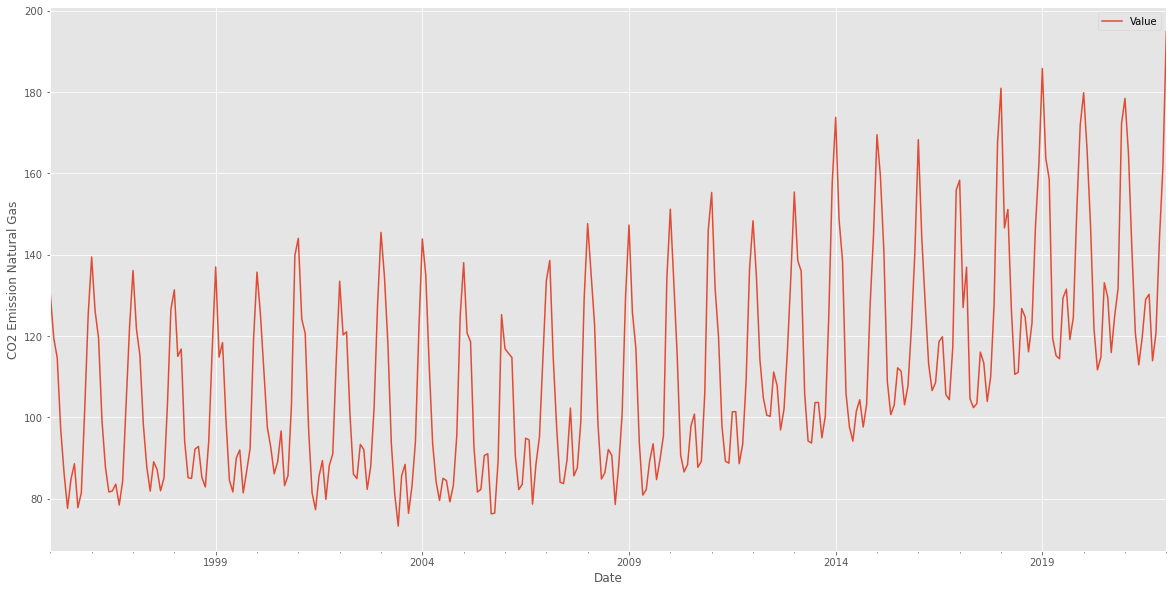

In [34]:
# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('CO2 Emission Natural Gas')
plt.xlabel('Date')
plt.show()

Two obvious patterns appear in the data, an overall increase in CO emission by Natural Gas, and a 12 months seasonality.

SARIMAX results returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of 
the model and the complexity of the model itself.

In [36]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We select a subset of the data series as training data, say the first 25 years. Our goal is to predict the last year of
the series based on this input.

In [37]:
train_data = data['1995-01-01':'2020-12-01']
test_data = data['2021-01-01':'2021-12-01']

In [38]:
print(test_data)

              Value
Month              
2021-01-01  178.400
2021-02-01  164.960
2021-03-01  141.453
2021-04-01  120.799
2021-05-01  112.892
2021-06-01  119.647
2021-07-01  128.985
2021-08-01  130.237
2021-09-01  113.889
2021-10-01  120.761
2021-11-01  143.770
2021-12-01  161.270


In [39]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [40]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))


The smallest AIC is 1636.6222317534582 for model SARIMAX(3, 1, 1)x(3, 1, 1, 12)


In [41]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated.
To do this, we can use the plot_diagnostics method.

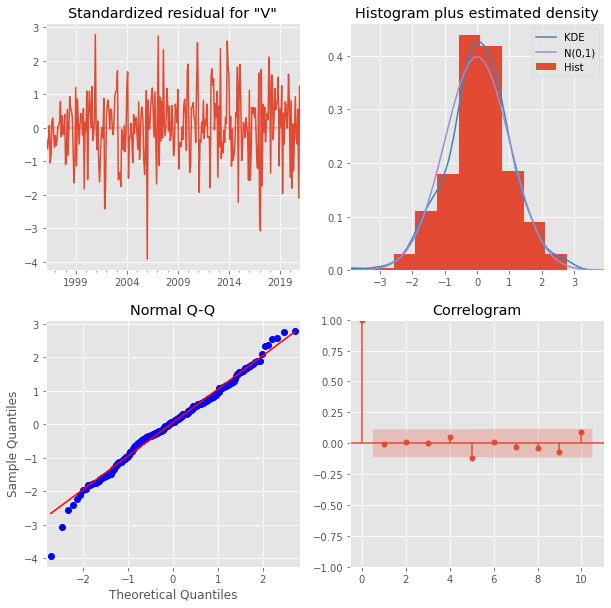

In [42]:
results.plot_diagnostics(figsize=(10, 10))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious 
seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot).
The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend
of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals 
are normally distributed.

RESULTS
Now let's create some predictions. We will use three methods:
1) In sample prediction with 1-step ahead forecasting of the last year (2019 AND 2020). In this case the model is used to predict 
data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the 
following one.

In [43]:
pred0 = results.get_prediction(start='2019-01-01',end='2020-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

2) In sample prediction with dynamic forecasting of the last year (2020 AND 2021). Again, the model is used to predict data that the model was built on.

In [44]:
pred1 = results.get_prediction(start='2020-01-01',end ='2021-12-01', dynamic=True)
pred1_ci = pred1.conf_int()

3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [45]:
pred2 = results.get_forecast('2023-02-01')
#pred2 = results.get_forecast(start='2023-02-01',end ='2021-12-01', dynamic=False)
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2021-01-01':'2021-12-01'])

2021-01-01    183.993606
2021-02-01    158.594823
2021-03-01    152.573275
2021-04-01    127.110613
2021-05-01    118.415585
2021-06-01    119.904333
2021-07-01    133.514768
2021-08-01    131.700575
2021-09-01    120.841232
2021-10-01    126.606515
2021-11-01    141.602247
2021-12-01    174.186764
Freq: MS, Name: predicted_mean, dtype: float64


Let's plot all this

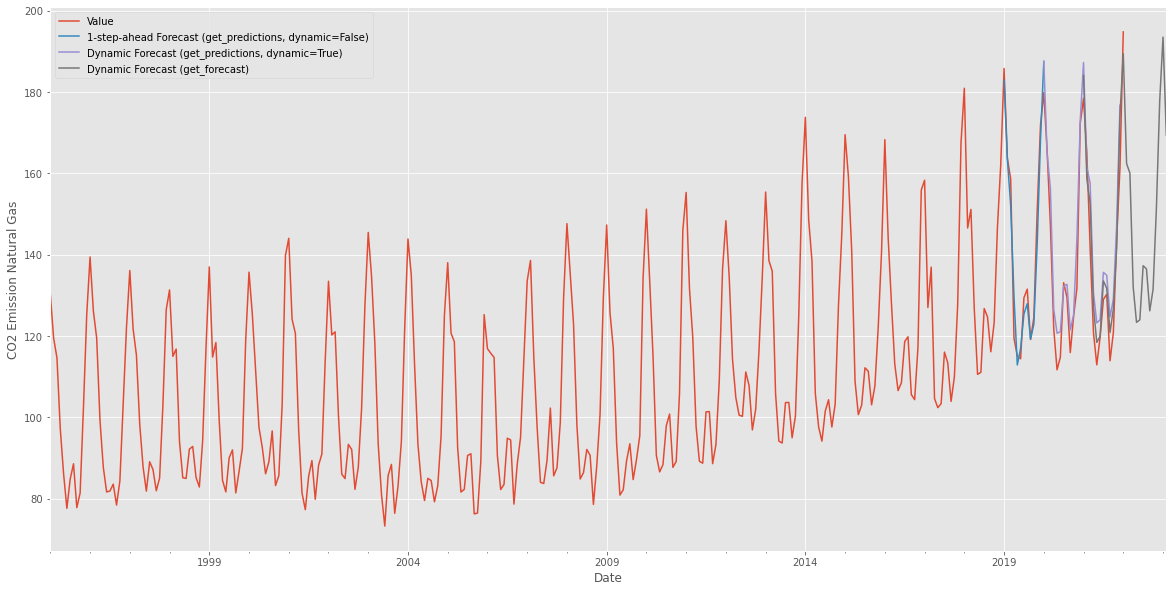

In [46]:
ax = data.plot(figsize=(20, 10))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
plt.ylabel('CO2 Emission Natural Gas')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, 
as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample predinction. 
For such a simple time series, the ARIMA model is able to forecast the 2023 values accurately.

In order to quantify the accuracy of the prediction for 2021, we can compute metrics such as Mean Absolute Error, Mean Squared Error, or Root Mean Squared Error. These are all absolute metrics, are therefore scale-dependent. While they are useful, and widely used to compare different methods on a same dataset, here it would be more useful to express the error relatively to the magnitude of the time series we are trying to predict. One commonly-used percentage error measure is the Mean Absolute Percentage Error (MAPE). It has some drawbacks in special cases (notably, it can lead to division by zero) and improved measures have been proposed, see e.g. https://www.otexts.org/fpp/2/5 for a nice overview. However, for this example we'll stick with MAPE.

In [48]:
prediction = pred2.predicted_mean['2021-01-01':'2021-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 2021 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 2021 is 4.19%
